<a href="https://colab.research.google.com/github/YigitDemirsan/Enhancing-Big-Data-Access-Control-A-GCN-Based-Link-Prediction-Model/blob/main/CS550_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS550 Project-2

In [ ]:
!python --version
!pip install umap-learn matplotlib seaborn tensorflow
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric


Python 3.10.12


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Libaries

In [ ]:
from keras.optimizers import Adam
from keras.models import Sequential, load_model, Model
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from sklearn.preprocessing import LabelBinarizer
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import numpy as np
from sklearn.preprocessing import LabelBinarizer
import torch
import torch.nn as nn
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import torch.optim as optim
from torch_geometric.nn import global_mean_pool
import pandas as pd
import json
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Data

In [ ]:


# Read in edges and features
edges = pd.read_csv('git_edges.csv')[['node_1', 'node_2']]
edges.columns = ['source', 'target']
with open('git_features.json') as json_data:
    features = json.load(json_data)
node_features = pd.DataFrame.from_dict(features, orient='index')

# Read and prepare target data
train_targets = pd.read_csv('train.csv')
val_targets = pd.read_csv('Val.csv')
test_targets = pd.read_csv('test.csv')


In [ ]:
# Concatenate all node labels and find unique labels
all_nodes = pd.concat([edges['source'], edges['target']]).unique()

# Create a mapping from node labels to integers
node_mapping = {node: idx for idx, node in enumerate(all_nodes)}

# Map the source and target nodes to integers
edges['source'] = edges['source'].map(node_mapping)
edges['target'] = edges['target'].map(node_mapping)


In [ ]:
# Convert edges to tensor
edge_index = torch.tensor(edges.values.T, dtype=torch.long)

# Reindex node_features according to the node_mapping
node_features_reordered = pd.DataFrame(index=all_nodes)
node_features_reordered = node_features_reordered.join(node_features).fillna(0)

# Convert node features to tensor
x = torch.tensor(node_features_reordered.values, dtype=torch.float)


In [ ]:


# Assuming the second column is the label column
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(train_targets.iloc[:, 1])

# Number of unique classes
num_classes = len(label_encoder.classes_)

# Convert to tensor
y_tensor = torch.tensor(labels_encoded, dtype=torch.long)

# Rest of your model building and training code...



In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GCN(num_features=x.shape[1], num_classes=num_classes)


In [ ]:


# Placeholder data (replac0e with your actual data)
x = torch.randn(21860, 64)  # Node features (21860 nodes, 64 features)
edge_index = torch.randint(0, 21860, (2, 30000))  # Edge connectivity information
y = torch.randint(0, 11, (21860,))  # Integer labels (21860 nodes, 11 classes)

# Determine the number of nodes and classes
num_nodes = x.shape[0]
num_classes = y.max().item() + 1

# Create masks for train, validation, and test sets
train_mask = torch.zeros(num_nodes, dtype=torch.bool).scatter_(0, torch.randperm(num_nodes)[:int(num_nodes * 0.8)], True)
val_mask = torch.zeros(num_nodes, dtype=torch.bool).scatter_(0, torch.randperm(num_nodes)[:int(num_nodes * 0.1)], True)
test_mask = torch.zeros(num_nodes, dtype=torch.bool).scatter_(0, torch.randperm(num_nodes)[:int(num_nodes * 0.1)], True)

# Define your GNN model
class YourModel(nn.Module):
    def __init__(self, num_features, num_classes):
        super(YourModel, self).__init__()
        self.conv1 = GCNConv(num_features, 32)
        self.conv2 = GCNConv(32, 16)
        self.fc = nn.Linear(16, num_classes)

    def forward(self, x, edge_index, batch=None):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.fc(x)  # Do not aggregate across nodes here
        return x

# Initialize your model
model = YourModel(num_features=x.shape[1], num_classes=num_classes)

# Define your optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Create DataLoader
data = Data(x=x, edge_index=edge_index, y=y)
batch_size = 64
train_loader = DataLoader([data], batch_size=batch_size, shuffle=True)

def to_one_hot(labels, num_classes):
    return torch.nn.functional.one_hot(labels, num_classes).to(torch.float32)

# Convert labels to one-hot encoding
y_one_hot = to_one_hot(y, num_classes)


def train():
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        # Forward pass
        out = model(batch.x, batch.edge_index, batch.batch)

        # Prepare target labels for the current batch (one-hot encoded)
        batch_labels = y_one_hot[batch.batch]  # Extract labels for nodes in the batch

        # Compute loss
        loss = F.mse_loss(out, batch_labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(train_loader)

# For validation set
val_data = Data(x=x, edge_index=edge_index, y=y, mask=val_mask)  # Ensure mask is included
val_loader = DataLoader([val_data], batch_size=batch_size, shuffle=False)

# For test set
test_data = Data(x=x, edge_index=edge_index, y=y, mask=test_mask)  # Ensure mask is included
test_loader = DataLoader([test_data], batch_size=batch_size, shuffle=False)


def evaluate(loader):
    model.eval()
    total_correct = 0
    total_nodes = 0

    for batch in loader:
        logits = model(batch.x, batch.edge_index, batch.batch)
        pred = logits.max(1)[1]

        # Only consider nodes that are part of the mask
        batch_mask = batch.mask
        correct_preds = pred[batch_mask].eq(batch.y[batch_mask]).sum().item()

        total_correct += correct_preds
        total_nodes += batch_mask.sum().item()

    return total_correct / total_nodes if total_nodes > 0 else 0


criterion = nn.MSELoss()

# Lists to store metrics
train_losses = []
val_accuracies = []

for epoch in range(200):
    train_loss = train()
    train_losses.append(train_loss)

    val_acc = evaluate(val_loader)  # Use the validation DataLoader
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch + 1}, Loss: {train_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

# Evaluate on test set
test_acc = evaluate(test_loader)  # Use the test DataLoader
print(f'Test Accuracy: {test_acc:.4f}')


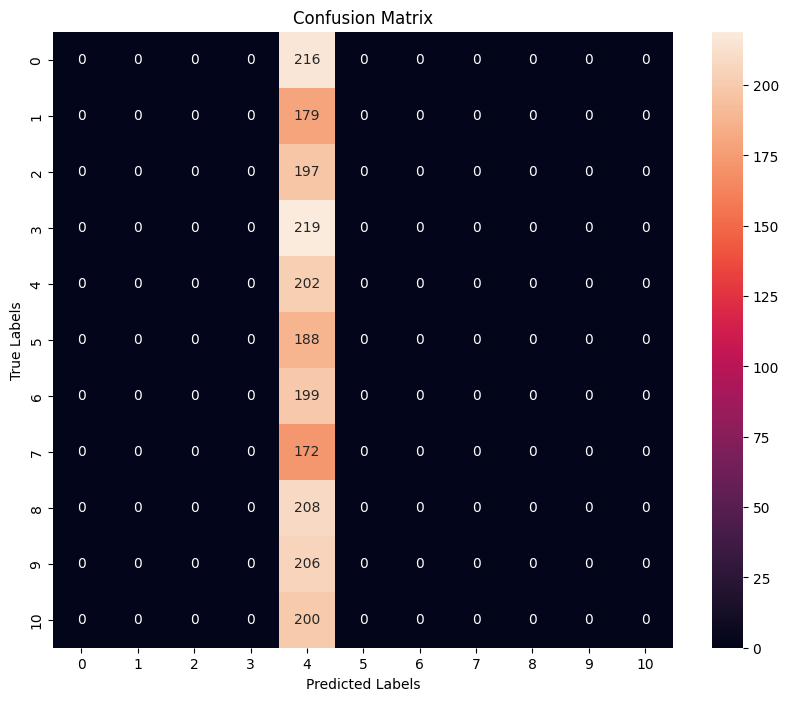

In [ ]:
def evaluate_and_collect(loader):
    model.eval()
    all_preds = []
    all_labels = []

    for batch in loader:
        logits = model(batch.x, batch.edge_index, batch.batch)
        pred = logits.max(1)[1]

        batch_mask = batch.mask
        all_preds.extend(pred[batch_mask].tolist())
        all_labels.extend(batch.y[batch_mask].tolist())

    return all_preds, all_labels



# Evaluate and collect predictions and labels
val_preds, val_labels = evaluate_and_collect(val_loader)

# Compute confusion matrix
conf_matrix = confusion_matrix(val_labels, val_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()




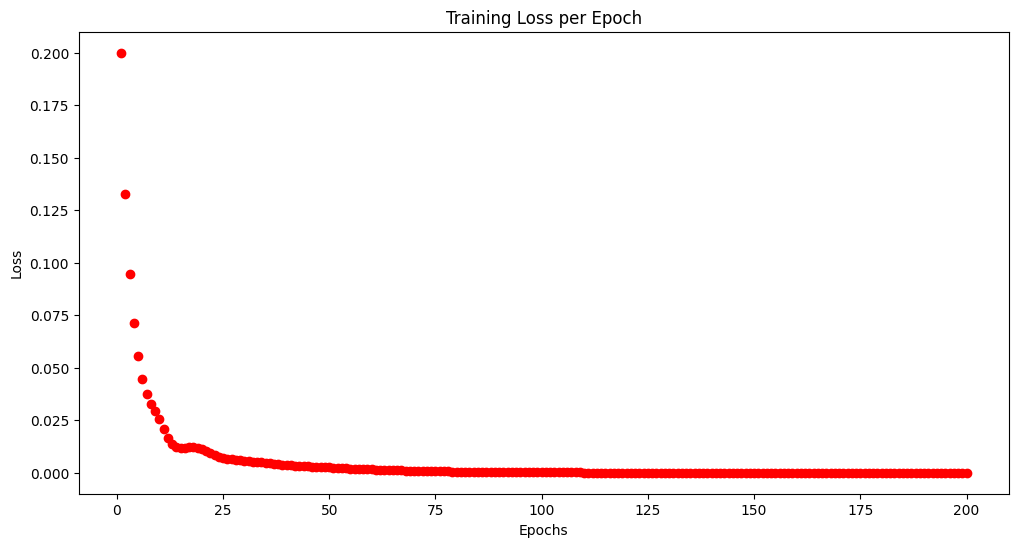

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(epochs, train_losses, color='red')
plt.title('Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

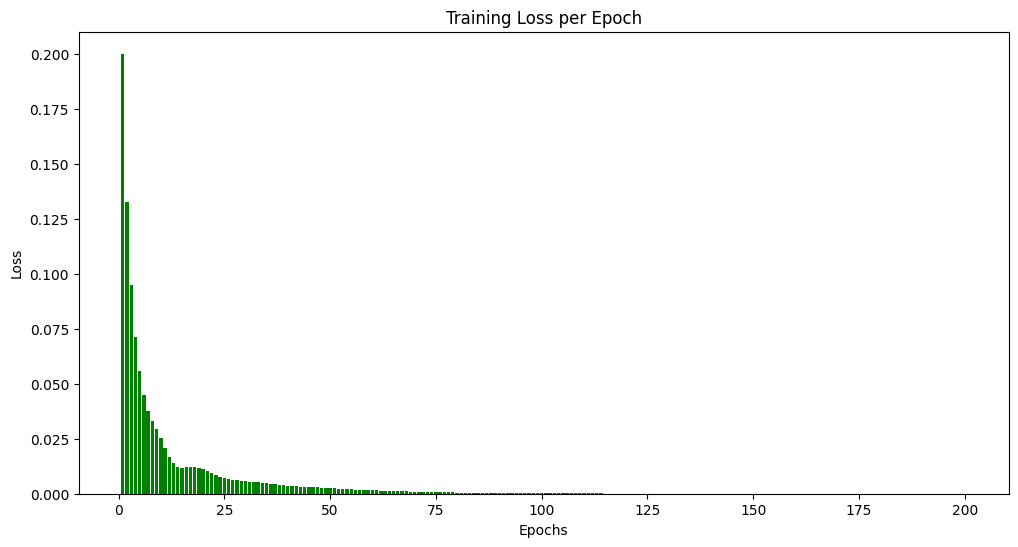

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(epochs, train_losses, color='green')
plt.title('Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# GCN Model Build Part

*Hyper-Parameters for the GCN Model*

In [ ]:
# Initialise GCN parameters
kernel_initializer="glorot_uniform"
bias = True
bias_initializer="zeros"
n_layers = 2
layer_sizes = [32, 32]
dropout = 0.5
n_features = features_input.shape[2]
n_nodes = features_input.shape[1]

*Input Layers*

In [ ]:
# Initialise input layers
x_features = Input(batch_shape=(1, n_nodes, n_features))
x_indices = Input(batch_shape=(1, None), dtype="int32")
x_adjacency = Input(batch_shape=(1, n_nodes, n_nodes))
x_inp = [x_features, x_indices, x_adjacency]

*GCN Model Build*

In [ ]:
# Build the model
x = Dropout(0.5)(x_features)
x = GraphConvolution(32, activation='relu',
                     use_bias=True,
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer)([x, x_adjacency])
x = Dropout(0.5)(x)
x = GraphConvolution(32, activation='relu',
                     use_bias=True,
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer)([x, x_adjacency])

x = GatherIndices(batch_dims=1)([x, x_indices])
output = Dense(1, activation='relu')(x)

model = Model(inputs=[x_features, x_indices, x_adjacency], outputs=output)

# Print out the summary
model.summary()

*Model Fit*

In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=losses.binary_crossentropy,
    metrics=["acc"],
)

# Early stopping callback
es_callback = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Fit the model
history = model.fit(
    x = [features_input, train_indices, A_input], # 3 inputs - features matrix, train indices, normalised adjacency matrix
    y = y_train,
    batch_size = 32,
    epochs=200,
    validation_data=([features_input, val_indices, A_input], y_val),
    verbose=1,
    shuffle=False,
    callbacks=[es_callback],
)

NameError: name 'model' is not defined

*Model Evaluation*

In [ ]:
# Function to evaluate
def evaluate_preds(true, pred):
    auc = roc_auc_score(true, pred)
    pr = average_precision_score(true, pred)
    bin_pred = [1 if p > 0.5 else 0 for p in pred]
    f_score = f1_score(true, bin_pred)
    print('ROC AUC:', auc)
    print('PR AUC:', pr)
    print('F1 score:', f_score)
    print(confusion_matrix(true, bin_pred, normalize='true'))

    return auc, pr, f_score

auc, pr, f_score = evaluate_preds(test_targets.ravel(),test_preds[0].ravel())

NameError: name 'test_targets' is not defined

*Plot Of the Model*

In [ ]:
# Define the embedding model
embedding_model = Model(inputs=x_inp, outputs=model.layers[-2].output)

# Get indices of all nodes
all_indices = get_node_indices(G, targets.index)

#Get embeddings
emb = embedding_model.predict([features_input, all_indices, A_input])
print(emb.shape)
# Shape: (1, 37700, 32)

# UMAP for visualisation
u = umap.UMAP(random_state=42)
umap_embs = u.fit_transform(emb[0])

#Plot the embeddingsembe
plt.figure(figsize=(20,10))
ax = sns.scatterplot(x = umap_embs[:, 0], y = umap_embs[:, 1], hue = targets['ml_target'])